In [32]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import admix
import os
import pandas as pd
import numpy as np
import glob
import json
from scipy.interpolate import CubicSpline
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import string

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
# SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp-tables.xlsx?dl=1"
SUPP_TABLE_URL = "supp-tables.xlsx"
snpset = "imputed.mafukb.005"

In [3]:
# UKB
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="ukb-trait-info")
ukb_trait_list = df_trait_info[df_trait_info["in-analysis"] == "T"].id.values
ukb_name_dict = (
    df_trait_info[["id", "display-name"]].set_index("id")["display-name"].to_dict()
)

# PAGE
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="page-trait-info")
page_trait_list = df_trait_info.trait.values
page_name_dict = (
    df_trait_info[["trait", "display-name"]]
    .set_index("trait")["display-name"]
    .to_dict()
)

aou_name_dict = {
    "bmi": "BMI",
    "diastolic_blood_pressure": "Diastolic blood pressure",
    "systolic_blood_pressure": "Systolic blood pressure",
    "HDL": "HDL",
    "LDL_adjusted": "LDL",
    "heart_rate": "Heart rate",
    "height": "Height",
    "TC_adjusted": "Total cholesterol",
    "TG_adjusted": "Triglycerides",
    "waist_hip_ratio": "WHR",
}

In [4]:
RUN = False
if RUN:
    for study in ["ukb", "page"]:
        if study == "ukb":
            # UKB traits
            root_est_dir = "/u/home/k/kangchen/project-UKBB/UKB-ADMIXED/02-genet-cor/out/gcta-estimate/"
            trait_list = ukb_trait_list
            scale_factor = admix.tools.gcta.calculate_hsq_scale(
                weight_file=f"/u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/admix-grm/{snpset}.merged.weight.tsv",
                freq_file="/u/project/sgss/UKBB/UKB-ADMIXED/01-dataset/out/PLINK2/imputed/*.snp_info",
            )
        elif study == "page":
            root_est_dir = (
                "/u/project/pasaniuc/kangchen/2021-admix-corr/experiments/"
                "03-page-genome-wide-profile-likelihood-new/out/gcta-estimate/"
            )
            trait_list = page_trait_list
            scale_factor = admix.tools.gcta.calculate_hsq_scale(
                weight_file=f"/u/scratch/k/kangchen/admix-grm/{snpset}.merged.weight.tsv",
                freq_file="/u/home/k/kangchen/PAGE-QC/01-dataset/out/aframr/imputed/*.snp_info",
                index_col="SNP",
            )
        out_dir = f"results/raw/{study}"
        os.makedirs(out_dir, exist_ok=True)
        for trait in trait_list:
            est_dir = os.path.join(root_est_dir, f"{trait}-sample10pc-{snpset}")
            admix.cli.summarize_genetic_cor(
                est_dir=est_dir,
                out_prefix=os.path.join(out_dir, trait),
                scale_factor=scale_factor,
            )

In [5]:
for study in ["ukb", "page", "aou"]:
    print(f"In study {study}")
    admix.cli.meta_analyze_genetic_cor(f"results/raw/{study}/*loglkl.txt")
    print("")

print("Overall:")
admix.cli.meta_analyze_genetic_cor(f"results/raw/*/*loglkl.txt")

In study ukb
Meta-analysis results across 26 files
-------------------------------------
rg mode  = 0.981
50% HPDI = [0.964, 0.996]
95% HPDI = [0.912, 1]
Null (rg = 1) p-value: 0.549

In study page
Meta-analysis results across 24 files
-------------------------------------
rg mode  = 0.902
50% HPDI = [0.887, 0.916]
95% HPDI = [0.854, 0.943]
Null (rg = 1) p-value: 1.337e-07

In study aou
Meta-analysis results across 10 files
-------------------------------------
rg mode  = 0.971
50% HPDI = [0.961, 0.98]
95% HPDI = [0.943, 0.997]
Null (rg = 1) p-value: 0.04581

Overall:
Meta-analysis results across 60 files
-------------------------------------
rg mode  = 0.947
50% HPDI = [0.94, 0.954]
95% HPDI = [0.925, 0.969]
Null (rg = 1) p-value: 8.689e-07


In [6]:
df_tbl = []
for study in ["ukb", "page", "aou"]:
    file_list = glob.glob(f"results/raw/{study}/*.summary.json")
    dict_name = {"ukb": ukb_name_dict, "page": page_name_dict, "aou": aou_name_dict}[
        study
    ]
    dict_study = {"ukb": "UKBB", "page": "PAGE", "aou": "AoU"}
    for f in file_list:
        with open(f) as fh:
            data = json.load(fh)
        trait_id = f.split("/")[-1][: -len(".summary.json")]
        trait_name = dict_name[trait_id]
        hdpi = data["rg_hpdi(95%)"]
        if isinstance(hdpi[0], float):
            hdpi = f"[{hdpi[0]:.2f}, {hdpi[1]:.2f}]"
        elif isinstance(hdpi[0], list):
            hdpi = " ".join([f"[{i[0]:.2f}, {i[1]:.2f}]" for i in hdpi])
        df_tbl.append(
            [
                dict_study[study],
                trait_name,
                data["n"],
                data["rg_mode"],
                hdpi,
                f"{data['rg=1_pval']:.2g}",
                f"{data['hsq_est']:.2g} ± {data['hsq_stderr']:.2g}",
            ]
        )
df_tbl = pd.DataFrame(
    df_tbl,
    columns=[
        "Study",
        "Trait",
        "N",
        "Mode",
        "95% credible interval(s)",
        "p-value",
        "h2g",
    ],
)

In [7]:
from scipy.stats import spearmanr

In [8]:
def extract_error(df):
    ci = df.iloc[:, 3]
    ci_low = np.array([i.split(",")[0].lstrip("[") for i in ci]).astype(float)
    ci_high = np.array([i.split(",")[1].rstrip("]") for i in ci]).astype(float)
    mode = df.iloc[:, 2].values
    return mode - ci_low, ci_high - mode

,Study,N,Mode,95% credible interval(s),p-value,h2g
Trait,,,,,,
BMI,PAGE,16684,0.929,"[0.81, 1.00]",0.14,0.23 ± 0.024
Diastolic blood pressure,PAGE,11005,1.000,"[0.06, 1.00]",1,0.037 ± 0.028
HDL,PAGE,9929,0.788,"[0.10, 0.99]",0.1,0.13 ± 0.036
Height,PAGE,16705,0.902,"[0.81, 0.97]",0.0042,0.39 ± 0.025
LDL,PAGE,9574,0.967,"[0.39, 1.00]",0.73,0.15 ± 0.037
Systolic blood pressure,PAGE,11006,1.000,"[0.11, 1.00]",1,0.073 ± 0.032
Total cholesterol,PAGE,9981,0.696,"[0.10, 0.92]",0.0053,0.18 ± 0.036
Triglycerides,PAGE,9896,0.792,"[0.17, 1.00]",0.062,0.15 ± 0.036
WHR,PAGE,10067,0.903,"[0.15, 1.00]",0.38,0.12 ± 0.035


In [19]:
shared_trait_list

Index(['BMI', 'Diastolic blood pressure', 'HDL', 'HbA1c', 'Height',
       'Hypertension', 'LDL', 'Platelet count', 'Systolic blood pressure',
       'Total cholesterol', 'Triglycerides', 'Type 2 diabetes',
       'White blood cell count'],
      dtype='object', name='Trait')

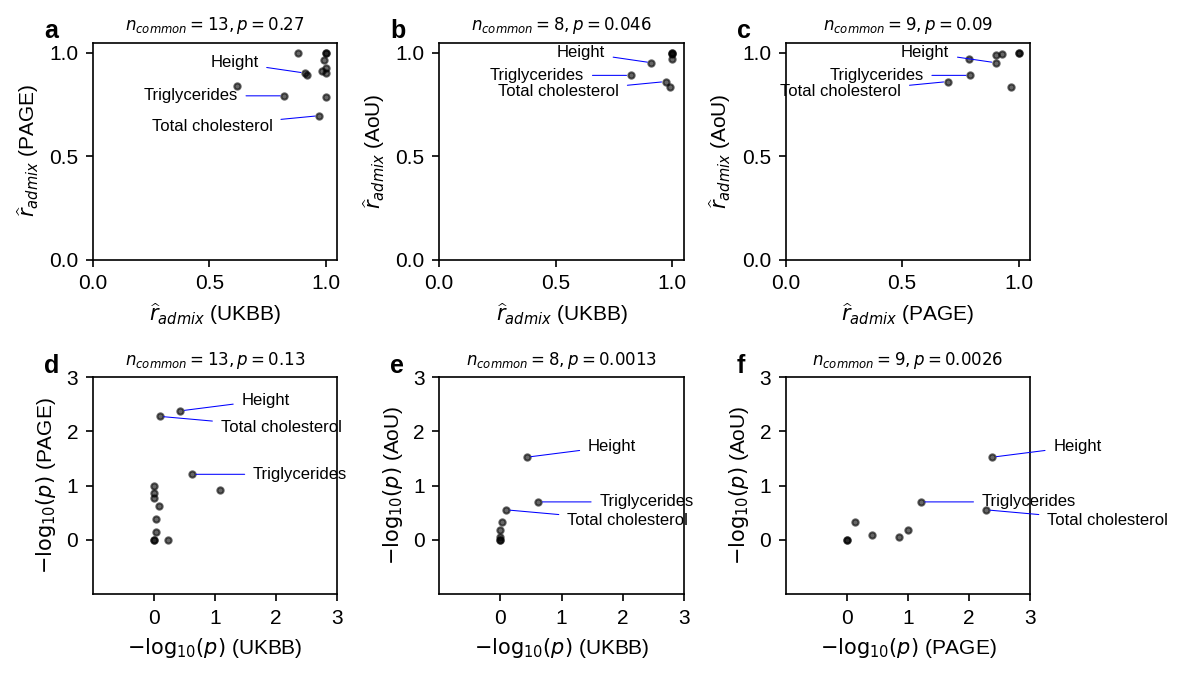

In [35]:
fig, axes = plt.subplots(figsize=(8, 4.6), dpi=150, ncols=3, nrows=2)
for i, pair in enumerate([["UKBB", "PAGE"], ["UKBB", "AoU"], ["PAGE", "AoU"]]):

    df_tmp = df_tbl[df_tbl.Study.isin(pair)]
    df_tmp1 = df_tmp.groupby("Trait").size()
    shared_trait_list = df_tmp1.index[df_tmp1 == 2]
    df_tmp1 = df_tmp[df_tmp.Study == pair[0]].set_index("Trait").loc[shared_trait_list]
    df_tmp2 = df_tmp[df_tmp.Study == pair[1]].set_index("Trait").loc[shared_trait_list]
    x_pval = -np.log10(df_tmp1["p-value"].astype(float).values)
    y_pval = -np.log10(df_tmp2["p-value"].astype(float).values)
    x_est = df_tmp1["Mode"]
    y_est = df_tmp2["Mode"]
    text_indices = np.where(
        shared_trait_list.isin(["Height", "Total cholesterol", "Triglycerides"])
    )[0]
    # estimates
    ax = axes[0, i]
    ax.errorbar(x=x_est, y=y_est, fmt=".", color="black", alpha=0.6)

    for j in text_indices:
        trait = shared_trait_list[j]
        if trait == "Height":
            offset = 0.05
        elif trait == "Total cholesterol":
            offset = -0.05
        else:
            offset = 0.0
        ax.annotate(
            shared_trait_list[j],
            xy=(x_est[j], y_est[j]),
            xytext=(x_est[j] - 0.2, y_est[j] + offset),
            ha="right",
            va="center",
            arrowprops=dict(arrowstyle="-", lw=0.5, color="blue"),
            fontsize=8,
        )

    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel("$\widehat{r}_{admix}$" + f" ({pair[0]})")
    ax.set_ylabel("$\widehat{r}_{admix}$" + f" ({pair[1]})")
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_yticks([0, 0.5, 1.0])
    r, p = spearmanr(x_est, y_est)
    ax.set_title("$n_{common} = $" + f"$ {len(df_tmp1)}, p={p:.2g}$", fontsize=8)
    ax.text(
        -0.2,
        1.02,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )
    ########################################################################
    # -log10(p)
    ax = axes[1, i]
    ax.errorbar(x=x_pval, y=y_pval, fmt=".", color="black", alpha=0.6)

    for j in text_indices:
        trait = shared_trait_list[j]
        if trait == "Height":
            offset = 0.2
        elif trait == "Total cholesterol":
            offset = -0.2
        else:
            offset = 0.0
        ax.annotate(
            shared_trait_list[j],
            xy=(x_pval[j], y_pval[j]),
            xytext=(x_pval[j] + 1.0, y_pval[j] + offset),
            ha="left",
            va="center",
            arrowprops=dict(arrowstyle="-", lw=0.5, color="blue"),
            fontsize=8,
        )

    ax.set_xlim(-1, 3)
    ax.set_ylim(-1, 3)
    ax.set_xlabel("$-\log_{10}(p)$" + f" ({pair[0]})")
    ax.set_ylabel("$-\log_{10}(p)$" + f" ({pair[1]})")
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yticks([0, 1, 2, 3])
    ax.text(
        -0.2,
        1.02,
        string.ascii_lowercase[i + 3],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

    r, p = spearmanr(x_pval, y_pval)
    ax.set_title("$n_{common} = $" + f"$ {len(df_tmp1)}, p={p:.2g}$", fontsize=8)


fig.tight_layout()
fig.savefig("results/consistency-across-study.pdf", bbox_inches="tight")

In [34]:
df_tbl_export = df_tbl.copy()
df_tbl_export["h2g"] = df_tbl_export["h2g"].apply(
    lambda h: "$" + "\pm".join(h.split("±")) + "$"
)
df_tbl_export = df_tbl_export.rename(columns={"h2g": "$h_g^2$"}).sort_values(
    ["Trait", "Study"]
)

In [36]:
with open("results/study-trait-rg.tex", "w") as f:
    f.write(df_tbl_export.to_latex(escape=False, index=False))

In [7]:
df_tbl.to_excel("results/study-trait-rg.xlsx")

In [8]:
print("Average number of individuals by study:")
print(df_tbl.groupby("Study").apply(lambda df: int(np.round(df["N"].mean()))))

print("\n\nNumber of traits shared across >= 2 studies:")
print(np.sum(df_tbl.groupby("Trait").size() >= 2))

Average number of individuals by study:
Study
AoU     20496
PAGE     9296
UKBB     3808
dtype: int64


Number of traits shared across >= 2 studies:
14


In [9]:
def meta_analyze_h2g(df):
    effects = np.array([float(i[0]) for i in df["h2g"].str.split("±")])
    se = np.array([float(i[1]) for i in df["h2g"].str.split("±")])
    if len(effects) == 1:
        ma = effects[0], se[0]
    else:
        ma = admix.data.meta_analysis(effects, se, method="random")
    return f"${ma[0]:.2g} \pm {ma[1]:.2g}$"

In [10]:
# number of individuals per trait
dense_rg_list = np.linspace(0, 1, 1001)
rg_list = None
dict_nindiv = {}
# loglikelihood curve per trait (agg across studies)
dict_loglik = {}

for study in ["ukb", "page", "aou"]:
    file_list = glob.glob(f"results/raw/{study}/*.summary.json")
    dict_name = {"ukb": ukb_name_dict, "page": page_name_dict, "aou": aou_name_dict}[
        study
    ]

    for f in file_list:
        with open(f) as fh:
            data = json.load(fh)
        trait_id = f.split("/")[-1][: -len(".summary.json")]
        trait_name = dict_name[trait_id]
        if trait_name not in dict_nindiv:
            dict_nindiv[trait_name] = []
        dict_nindiv[trait_name].append(data["n"])

        df_loglkl = pd.read_csv(f"results/raw/{study}/{trait_id}.loglkl.txt", sep="\t")
        if rg_list is None:
            rg_list = df_loglkl["rg"].values
        else:
            assert np.all(rg_list == df_loglkl["rg"].values)
        if trait_name not in dict_loglik:
            dict_loglik[trait_name] = 0
        dict_loglik[trait_name] += CubicSpline(rg_list, df_loglkl["loglkl"].values)(
            dense_rg_list
        )

assert list(dict_nindiv.keys()) == list(dict_loglik.keys())

In [11]:
df_tbl_trait = []

for trait in dict_loglik:
    loglik = dict_loglik[trait]
    mode = dense_rg_list[loglik.argmax()]
    hdpi = admix.data.hdi(dense_rg_list, loglik, ci=0.95)
    if isinstance(hdpi, tuple):
        hdpi = f"[{hdpi[0]:.2f}, {hdpi[1]:.2f}]"
    elif isinstance(hdpi, list):
        hdpi = " ".join([f"[{i[0]:.2f}, {i[1]:.2f}]" for i in hdpi])
    pval = stats.chi2.sf((loglik.max() - loglik[-1]) * 2, df=1)
    df_tbl_trait.append(
        [
            trait,
            np.sum(dict_nindiv[trait]),
            mode,
            hdpi,
            f"{pval:.2g}",
        ]
    )

df_tbl_trait = (
    pd.DataFrame(
        df_tbl_trait,
        columns=[
            "Trait",
            "N",
            "Mode",
            "95% credible interval(s)",
            "p-value",
        ],
    )
    .sort_values("N")
    .reset_index(drop=True)
).set_index("Trait")

df_tbl_trait["$h_g^2$"] = (
    df_tbl.groupby("Trait")
    .apply(lambda df: meta_analyze_h2g(df))
    .reindex(df_tbl_trait.index.values)
)

In [12]:
# trait that's significant after Bonferrnoni correction
display(
    df_tbl_trait[
        df_tbl_trait["p-value"].astype(float) < 0.05 / (len(df_tbl_trait))
    ].style.set_caption("Traits that are bonferroni significant")
)

,N,Mode,95% credible interval(s),p-value,$h_g^2$
Trait,,,,,
Height,49605,0.936000,"[0.89, 0.97]",0.00043,$0.4 \pm 0.014$


In [13]:
plot_trait_list = list(
    df_tbl_trait.sort_values("N", ascending=False).iloc[0:13].index.values
) + ["C-reactive protein", "MCH", "RBC count"]

df_plot = df_tbl_trait.loc[plot_trait_list, :].sort_values("N")
df_plot["display"] = df_plot.apply(
    lambda row: f"{row.name} ({int(np.round(row.N / 1000))}K)", axis=1
)
df_plot.loc["C-reactive protein", "display"] = df_plot.loc[
    "C-reactive protein", "display"
].replace("C-reactive protein", "CRP")
df_plot.loc["Total cholesterol", "display"] = df_plot.loc[
    "Total cholesterol", "display"
].replace("Total cholesterol", "TC")

dict_plot = {row.display: dict_loglik[row.name] for _, row in df_plot.iterrows()}
dict_plot["Meta-analysis (60 study-trait pairs)"] = np.sum(
    list(dict_loglik.values()), axis=0
)

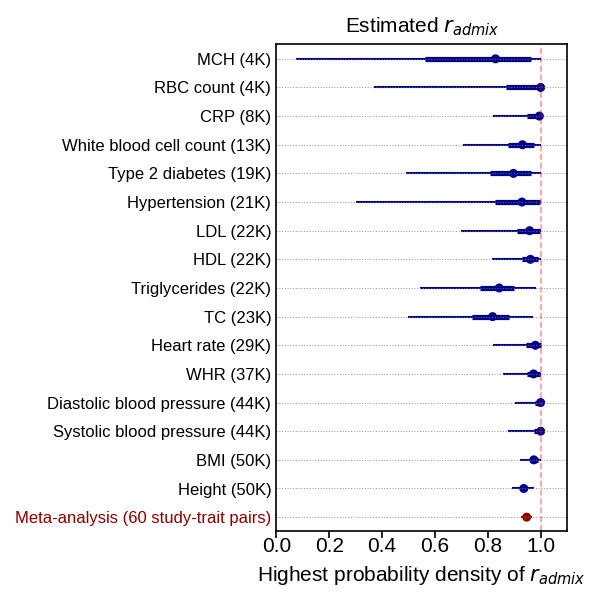

In [14]:
fig, ax = plt.subplots(figsize=(2.5, 4.3), dpi=150)
admix.plot.rg_posterior(
    dense_rg_list, dict_plot, colors=["darkblue"] * (len(dict_plot) - 1) + ["darkred"]
)
# set color for the meta-analysis
ax.get_yticklabels()[0].set_color("darkred")
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig("results/genome-wide-rg.pdf", bbox_inches="tight")
plt.show()

In [15]:
df_tbl_trait["N"] = df_tbl_trait["N"].astype(str)
# add meta-analysis results
total_loglik = np.sum(list(dict_loglik.values()), axis=0)
total_mode = dense_rg_list[total_loglik.argmax()]
total_ci = admix.data.hdi(dense_rg_list, total_loglik)
total_pval = stats.chi2.sf((total_loglik.max() - total_loglik[-1]) * 2, df=1)
df_tbl_trait.loc["Meta analysis", :] = [
    "",
    dense_rg_list[total_loglik.argmax()],
    f"[{total_ci[0]:.2g}, {total_ci[1]:.2g}]",
    f"{total_pval:.2g}",
    "",
]

In [20]:
with open("results/trait-rg.tex", "w") as f:
    f.write(df_tbl_trait.reset_index().to_latex(escape=False, index=False))